# Init

In [335]:
from metocean_stats import plots, tables
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [418]:
currentDf = pd.read_excel(r"C:\Users\vishnur\OneDrive - NTNU\WORK\task49\Humbolt_Current_time_series_800m.xlsx", sheet_name=None, dtype=str)

dfList = []
for key, item in currentDf.items():
    item['dateTime'] = pd.to_datetime(item['yyyy'] +'-' + item['mm']+'-' + item['dd'] + ' ' + item['hh'] +  ':00:00') 
    item = item.set_index('dateTime')
    item = item.drop(columns=['yyyy', 'mm', 'dd', 'hh'])
    item = item.astype(float)
    item.rename(columns={'Vc (m/s)': f'vc_{key}', 'Dir (°N)': f'dir_{key}'}, inplace=True)
    dfList.append(item)

df_current = pd.concat(dfList, axis=1)

In [337]:
metDf = pd.read_csv(r"C:\GitRepos\utilities\src\utilities\met_ocean_analysis\HumboldtBay_metocean1h.txt", sep = r'\s+', dtype=str, skiprows=[0, 1,2,3,5])
metDf['dateTime'] = pd.to_datetime(metDf['#YY'] + '-' + metDf['MM'] + '-' + metDf['DD'] + ' ' + metDf['hh'] + ':00:00')
metDf = metDf.set_index('dateTime')
metDf = metDf.drop(columns=['#YY', 'MM', 'DD', 'hh'])
metDf = metDf.astype(float)
metDf = metDf.dropna(subset='WDIR0m')

metDf['WSPD0m_u'] = -1 * metDf[f'WSPD0m'] * np.sin(np.deg2rad(metDf['WDIR0m']))
metDf['WSPD0m_v'] = -1 * metDf[f'WSPD0m'] * np.cos(np.deg2rad(metDf['WDIR0m']))
metDf_resampled = metDf.resample('3h').mean()
metDf_resampled['WDIR0m'] = np.mod(180 + np.rad2deg(np.arctan2(metDf['WSPD0m_u'], metDf['WSPD0m_v'])), 360)

# metDf_resampled.dropna(subset=['WSPD0m'], inplace=True)



# Current Return values

In [338]:
tables.table_profile_return_values(
    df_current,
    var=['vc_Surface', 'vc_10m', 'vc_50m', 'vc_100m'],
    z=[0, 10, 50, 100],
    periods=[1, 5, 50, 100, 500],
    output_file=''
)

,z,Return period 1 [years],Return period 5 [years],Return period 50 [years],Return period 100 [years],Return period 500 [years]
0,m,m/s,m/s,m/s,m/s,m/s
1,0,0.98,1.07,1.25,1.3,1.41
2,10,0.76,0.83,0.96,1.0,1.08
3,50,0.61,0.66,0.77,0.8,0.87
4,100,0.55,0.6,0.7,0.73,0.8


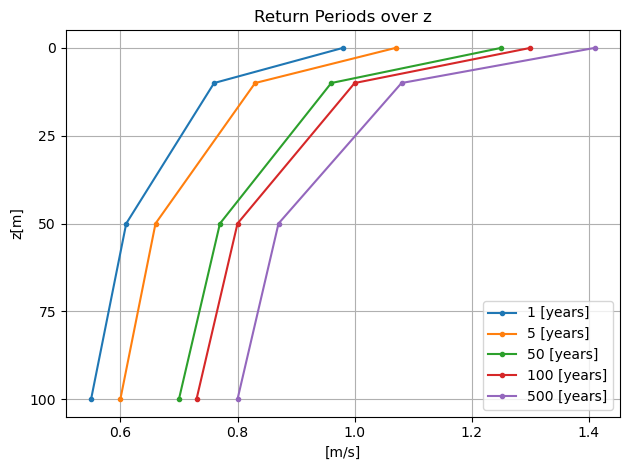

In [339]:
plot = plots.plot_profile_return_values(
            df_current,
            var=['vc_Surface', 'vc_10m', 'vc_50m', 'vc_100m'],
            z=[0, 10, 50, 100],
            periods=[1, 5, 50, 100, 500],
            reverse_yaxis=True,
            output_file=' '
        )

(np.float64(0.0),
 np.float64(6.283185307179586),
 np.float64(0.0),
 np.float64(1.0))

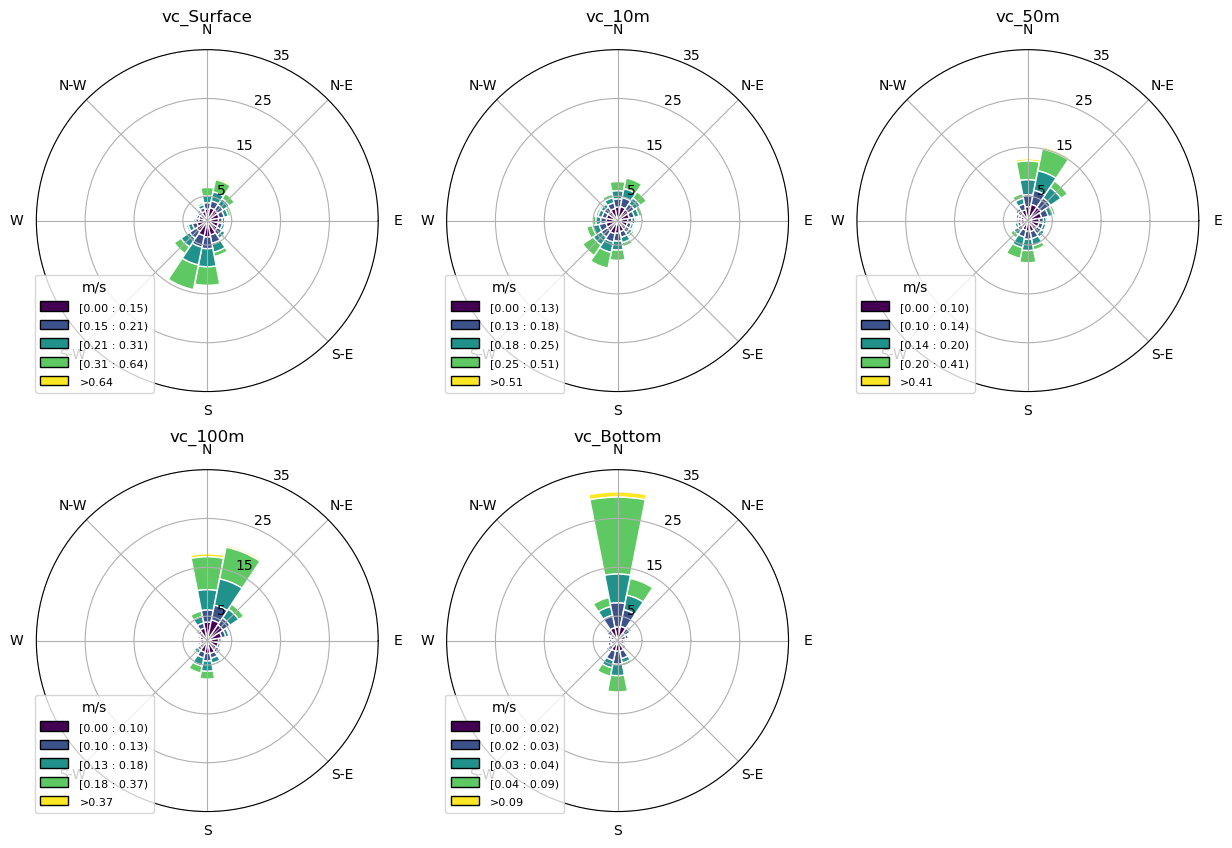

In [340]:
fig, axs = plt.subplots(2,3, figsize=(15, 10), subplot_kw={'projection': 'windrose'})
colHeaders = ['vc_Surface', 'vc_10m', 'vc_50m', 'vc_100m', 'vc_Bottom']

for i, (ax, var) in enumerate(zip(axs.flatten(), colHeaders)):

    plots.var_rose(
       df_current,
        f'dir{var.replace("vc", "")}',
        var,
        max_perc=30,
        decimal_places=2,
        units='m/s',
        method='overall',
        output_file='',
        ax=ax
    )

    ax.set_title(var, pad=20)

axs.flatten()[-1].axis('off')


# Scripps surface current data [2012 - 2023]

In [427]:
df_scripps = pd.read_csv(r"C:\GitRepos\utilities\src\utilities\met_ocean_analysis\RawTimeSeriesData\46022_surfacecurrents.txt", dtype=str, sep = r'\s+', skiprows=[0], names=['YY', 'MM', 'DD', 'hh', 'mm', 'Lat', 'Lon', 'Cdir', 'u', 'v', 'CurrMag'])
df_scripps['dateTime'] = pd.to_datetime(df_scripps['YY'] + '-' + df_scripps['MM'] + '-' + df_scripps['DD'] + ' ' + df_scripps['hh'] + ':' + df_scripps['mm'] + ':00')
df_scripps = df_scripps.set_index('dateTime')
df_scripps = df_scripps.drop(columns=['YY', 'MM', 'DD', 'hh', 'mm'])
df_scripps = df_scripps.astype(float)
# df_scripps['dir'] = np.mod(np.rad2deg(np.arctan2(df_scripps['u'], df_scripps['v'])), 360)
df_scripps.dropna(subset=['CurrMag'], inplace=True)


Text(0.5, 1.0, 'Scripps surface current at 0 m')

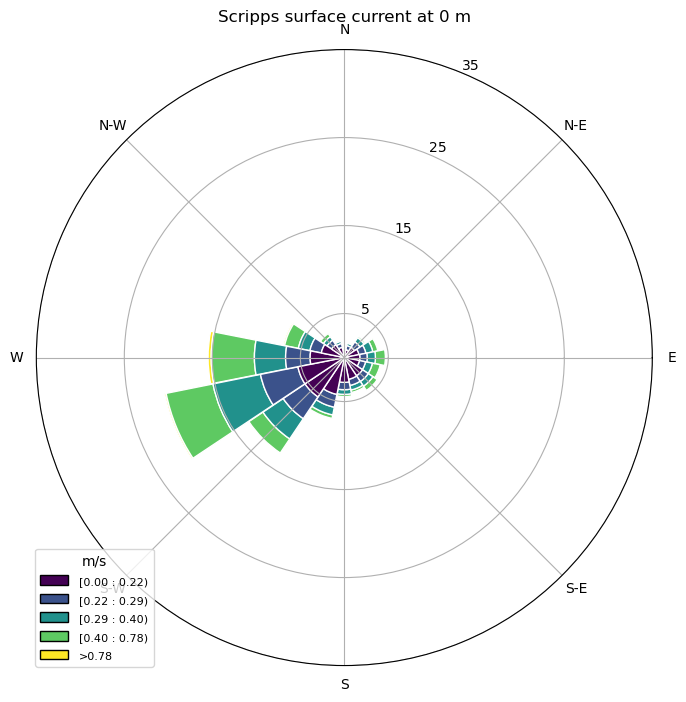

In [447]:
fig = plots.var_rose(
        df_scripps,
        'Cdir',
        'CurrMag',
        max_perc=30,
        decimal_places=2,
        units='m/s',
        method='overall',
        output_file='',
        ax=None
    )

ax = fig.get_axes()[0]
ax.set_title('Scripps surface current at 0 m', pad=20)

In [445]:
df_scripps_resampled = df_scripps.resample('3h').mean()
df_merged = df_current.join(df_scripps_resampled, how = 'inner')
df_merged = df_merged.dropna(subset=['CurrMag', 'vc_Surface'])

Text(0.5, 1.0, 'Correlation coefficient: 0.21')

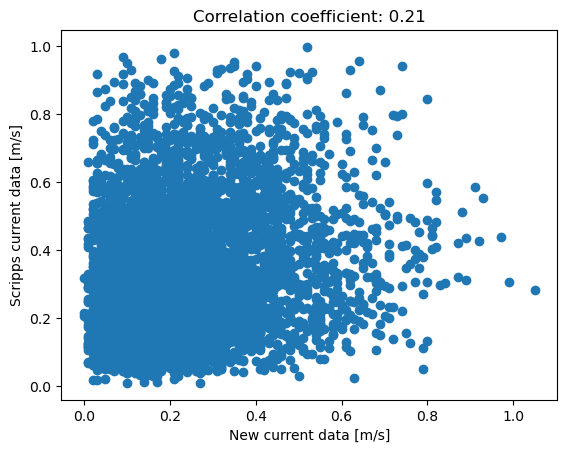

In [446]:
plt.plot(df_merged['vc_Surface'], df_merged['CurrMag'], 'o')
plt.xlabel('New current data [m/s]')
plt.ylabel('Scripps current data [m/s]')
#calculte the correlation coefficient
corr = df_merged['vc_Surface'].corr(df_merged['CurrMag'])
plt.title(f'Correlation coefficient: {corr:.2f}')




In [444]:
df_scripps = df_scripps.dropna(subset=['CurrMag'])
tables.table_profile_return_values(
    df_scripps,
    var=['CurrMag'],
    z=[0],
    periods=[1, 5, 50, 100, 500],
    output_file=''
)

,z,Return period 1 [years],Return period 5 [years],Return period 50 [years],Return period 100 [years],Return period 500 [years]
0,m,m/s,m/s,m/s,m/s,m/s
1,0,0.99,1.07,1.2,1.24,1.33


# Seperate into wind driven and tidal driven

## Wind rose plot

In [343]:
df = df_current.join(metDf_resampled, how='left')
df = df.dropna(subset=['WSPD0m'])

Text(0.5, 1.0, 'Wind speed at 0 m')

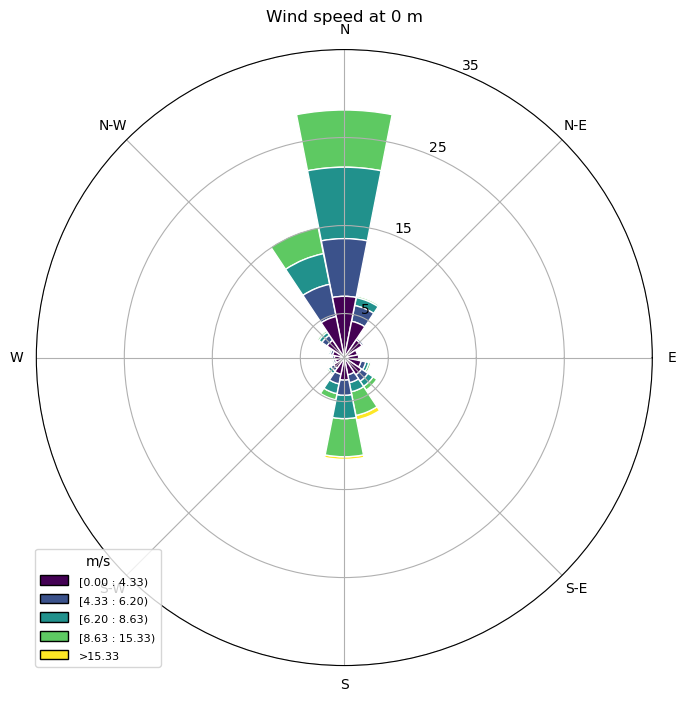

In [344]:
fig = plots.var_rose(
        df,
        'WDIR0m',
        'WSPD0m',
        max_perc=30,
        decimal_places=2,
        units='m/s',
        method='overall',
        output_file='',
        ax=None
    )

ax = fig.get_axes()[0]
ax.set_title('Wind speed at 0 m', pad=20)

## Time series correction

dateTime
1994-03-29 21:00:00    0.143377
1994-03-30 00:00:00    0.194931
1994-03-30 03:00:00    0.175396
1994-03-30 06:00:00    0.158940
1994-03-30 09:00:00    0.150580
                         ...   
2015-12-30 09:00:00    0.213632
2015-12-30 12:00:00    0.157791
2015-12-30 15:00:00    0.083184
2015-12-30 18:00:00    0.086981
2015-12-30 21:00:00    0.188182
Name: vc_50m_tidal_calc, Length: 49442, dtype: float64


Text(0.5, 1.0, 'R2 = 0.06')

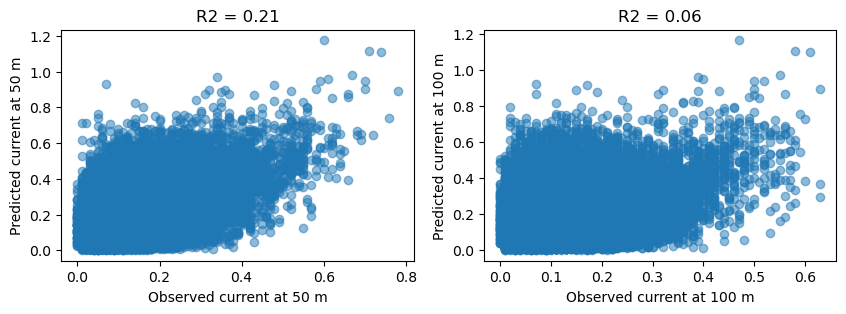

In [373]:
df_1 = df_current.join(metDf_resampled, how='left')
df = df_1.copy()
df = df.dropna(subset=['WSPD0m'])


def calculateCurComps(depth = 'Surface'):
    #split into u and v components - the direction is supposed to be the direction the current is going so no -1
    df[f'cur_{depth}_u'] = df[f'vc_{depth}'] * np.sin(np.deg2rad(df[f'dir_{depth}']))
    df[f'cur_{depth}_v'] = df[f'vc_{depth}'] * np.cos(np.deg2rad(df[f'dir_{depth}']))
    return df


def calcWindDrivenCur(df, d0, wind2curFact):
    
    calcWindCurDepthCor = lambda z: (d0 + -1*z)/d0
    
    df['vc_Surface_wind_u'] = wind2curFact  * df['WSPD0m_u']
    df['vc_Surface_wind_v' ]= wind2curFact  * df['WSPD0m_v']

    df['vc_10m_wind_u'] = df['vc_Surface_wind_u']  * calcWindCurDepthCor(10)
    df['vc_10m_wind_v'] = df['vc_Surface_wind_v'] * calcWindCurDepthCor(10)
    return df

def calculateTidalCurrent(depth = 'Surface'):
    df[f'vc_{depth}_tidal_u'] = df[f'cur_{depth}_u'] - df[f'vc_{depth}_wind_u']
    df[f'vc_{depth}_tidal_v'] = df[f'cur_{depth}_v'] - df[f'vc_{depth}_wind_v']

    df[f'vc_{depth}_tidal'] = np.sqrt(df[f'vc_{depth}_tidal_u']**2 + df[f'vc_{depth}_tidal_v']**2)
    df[f'dir_{depth}_tidal'] = np.mod(np.rad2deg(np.arctan2(df[f'vc_{depth}_tidal_u'], df[f'vc_{depth}_tidal_v'])), 360)
    return df


#split the total current into u adn v componenets
df = calculateCurComps('Surface')
df = calculateCurComps('10m')


#calcualte the wind driven current
wind2curFact = 0.015
d0 = 50
df = calcWindDrivenCur(df, d0, wind2curFact)

#calculate the tidal current
df = calculateTidalCurrent('Surface')
df = calculateTidalCurrent('10m')

#calcualte the predicted toidal currents at the other depths
alpha = 1/7
depth = 800

def calcTidalCurDepthCor(z, d, v0, alpha): 
    return v0 * ((d + -1*z)/d)**alpha

df['vc_50m_tidal_calc'] = calcTidalCurDepthCor(50, depth, df['vc_Surface_tidal'].values, alpha)
print(df['vc_50m_tidal_calc'])
df['vc_100m_tidal_calc'] = calcTidalCurDepthCor(100, depth, df['vc_Surface_tidal'].values, alpha)


fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs[0].plot(df['vc_50m'], df['vc_50m_tidal_calc'], 'o', alpha=0.5)
axs[0].set_xlabel('Observed current at 50 m')
axs[0].set_ylabel('Predicted current at 50 m')
#calcualte R2
r2 = np.corrcoef(df['vc_50m'], df['vc_50m_tidal_calc'])[0,1]**2
axs[0].set_title(f'R2 = {r2:.2f}')

axs[1].plot(df['vc_100m'], df['vc_100m_tidal_calc'], 'o', alpha=0.5)
axs[1].set_xlabel('Observed current at 100 m')
axs[1].set_ylabel('Predicted current at 100 m')
#calcualte R2
r2 = np.corrcoef(df['vc_100m'], df['vc_100m_tidal_calc'])[0,1]**2
axs[1].set_title(f'R2 = {r2:.2f}')




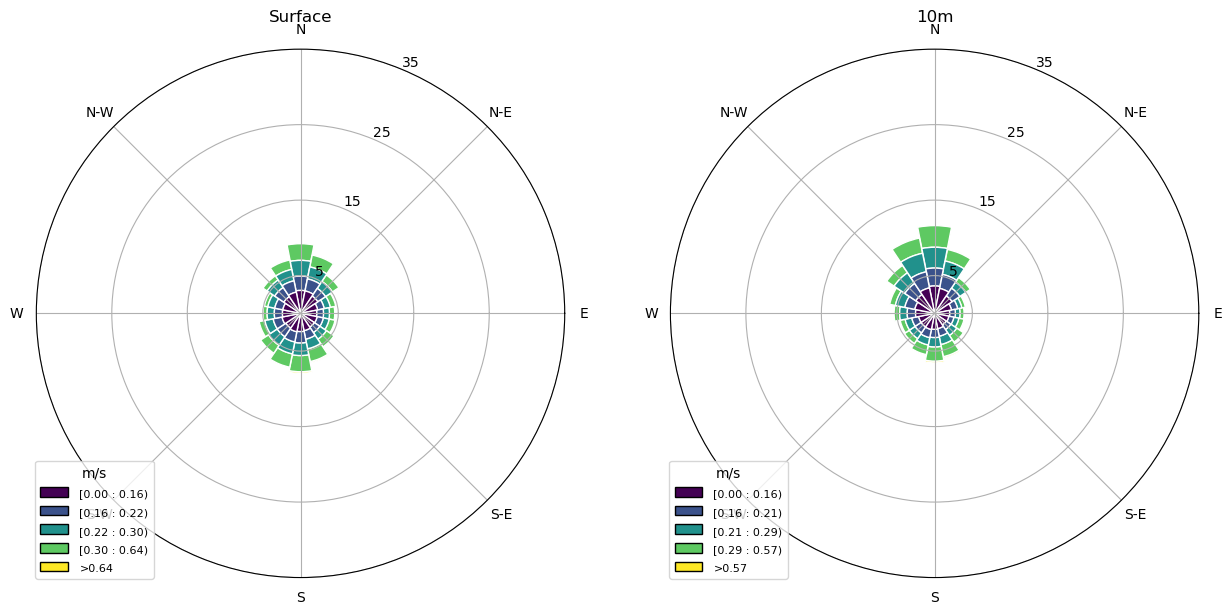

In [346]:
#plot tidal current
fig, axs = plt.subplots(1,2, figsize=(15, 10), subplot_kw={'projection': 'windrose'})

for i, (ax, depth) in enumerate(zip(axs.flatten(), ['Surface', '10m', '50m', '100m'])):

    plots.var_rose(
        df,
        f'dir_{depth}_tidal',
        f'vc_{depth}_tidal',
        max_perc=30,
        decimal_places=2,
        units='m/s',
        method='overall',
        output_file='',
        ax=ax
    )

    ax.set_title(depth, pad=20)
    

## Derive the wind factor from data

In [399]:
df_1 = df_current.join(metDf_resampled, how='left')
df = df_1.copy()
df = df.dropna(subset=['WSPD0m'])

Text(0.5, 1.0, 'R2 = 0.56')

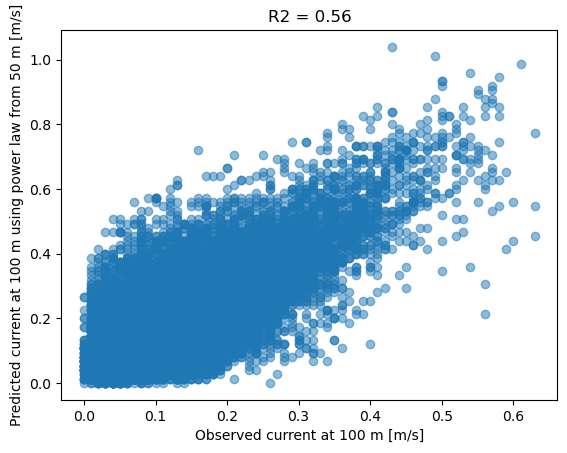

In [410]:
alpha = 1/7

df['vc_Surface_tidal'] = df['vc_50m'] * (800/(800-50))**alpha
df['dir_Surface_tidal'] = df['dir_50m']
df = calculateCurComps('Surface_tidal')
# df['vc_Surface_wind_u'] = df['vc_Surface_u'] - df['vc_Surface_u']


df['vc_100m_calc'] =  df['vc_Surface_tidal'] * ((800-100)/100)**alpha


plt.plot(df['vc_100m'], df['vc_100m_calc'], 'o', alpha=0.5)
plt.xlabel('Observed current at 100 m [m/s]')
plt.ylabel('Predicted current at 100 m using power law from 50 m [m/s]')
#calcualte R2
r2 = np.corrcoef(df['vc_100m'], df['vc_100m_calc'])[0,1]**2
plt.title(f'R2 = {r2:.2f}')
